In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl

import quimb.tensor as qtn

from qsp.misc_states import make_aklt_mps
from qsp.tsp import MPSPreparation
from qsp.tsp_helper_routines import make_splitted_mps

In [3]:
def get_target_mps(mps_type):
    if mps_type == "aklt":
        tensor_array, _ = make_aklt_mps(L=12)
        tensor_array = make_splitted_mps(tensor_array)
        target_mps = qtn.MatrixProductState(tensor_array, shape="lrp")

    if mps_type == "random":
        target_mps = qtn.MPS_rand_state(L=12, bond_dim=4)
        target_mps.permute_arrays(shape="lrp")

    if mps_type in ["P4", "N2", "heisenberg"]:
        filenames = {
            "P4": "data/P4_6-31G_dist2.0000.pkl",
            "N2": "data/N2_STO-6G_dist2.0000.pkl",
            "heisenberg": "data/heisenberg_L32_dist0.8000.pkl",
        }
        with open(filenames[mps_type], "rb") as f:
            data = pkl.load(f)
        target_mps = data["quimb_mps"]
        
    return target_mps


def dump_obj(file_name, obj):
    with open(f'data_benchmark/{file_name}', "wb") as f:
        pkl.dump(obj, f)


def load_obj(file_name):
    with open(f'data_benchmark/{file_name}', "rb") as f:
        obj = pkl.load(f)
    return obj

<h4 align="left">
	Run different preparations for various mps
</h4>

In [ ]:
mps_types = ["random", "aklt", "N2", "heisenberg"]
for mps_type in mps_types:
    print(f"preparing {mps_type} state")
    target_mps = get_target_mps(mps_type)
    prep = MPSPreparation(target_mps)    

    # sequential mps preparation        
    data = {}
    for num_seq_layers in [2, 4, 8, 12, 16]:
        data[num_seq_layers] = prep.sequential_unitary_circuit(
            num_seq_layers, do_compression=True, max_bond_dim=256
            )
    dump_obj(f"{mps_type}_data_seq.pkl", data)
            
    # variational mps preparation with sequential circicuit ansatz
    data = {}
    for num_var_seq_layers in [2, 3, 4]:
        data[num_var_seq_layers] = prep.sequential_unitary_circuit_optimization(
            num_var_seq_layers,  do_compression=True, max_bond_dim=256, 
            max_iterations=600
            )
    dump_obj(f"{mps_type}_data_var_seq.pkl", data)
    
    # quantum circuit tensor network ansatz
    data = {}
    for qctn_depth in [2,4,6]:
        data[qctn_depth] = prep.quantum_circuit_tensor_network_ansatz(
            qctn_depth, max_iterations=600
            )
    dump_obj(f"{mps_type}_data_qctn.pkl", data)
    
    ###### lcu mps preparation
    data = {}
    for num_lcu_layers in [2,4,8,16]:    
        data[num_lcu_layers] = prep.lcu_unitary_circuit(num_lcu_layers)
    dump_obj(f"{mps_type}_data_lcu.pkl", data)
    
    ###### variational mps preparation with lcu ansatz
    data = {}
    for num_var_lcu_layers in [2, 4, 8]:
        data[num_var_lcu_layers] = prep.lcu_unitary_circuit_optimization(
            num_var_lcu_layers, max_iterations=500
            )
    dump_obj(f"{mps_type}_data_var_lcu.pkl", data)

/tmp/ipykernel_33152/1236463238.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


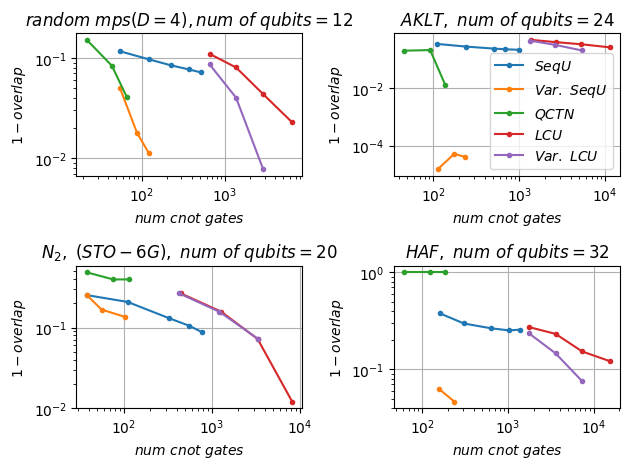

In [7]:
title_labels = {"aklt": "AKLT,\ num\ of\ qubits=24", 
                "heisenberg": "HAF,\ num\ of\ qubits=32",
                "random": "random\ mps (D=4), num\ of\ qubits=12", 
                "N2": "N_2,\ (STO-6G),\ num\ of\ qubits=20"}

method_labels = {'seq':'SeqU','var_seq':'Var.\ SeqU', 
                    'qctn':'QCTN',
                    'lcu':'LCU' ,'var_lcu':'Var.\ LCU'}
for mps_it, mps_type in enumerate(mps_types):
    plt.subplot(2,2,mps_it+1)
    for method in ['seq','var_seq','qctn','lcu','var_lcu']:
        data = load_obj(f"{mps_type}_data_{method}.pkl")
        xx = [(circ.num_nonlocal_gates(), np.abs(overlaps)) 
                    for num_layers, (overlaps, circ) in data.items()]
        xx = np.array(xx)
        plt.plot((xx[:,0]), (1-xx[:,1]), '.-', label=rf'${method_labels[method]}$')
        if mps_it==1:
            plt.legend()
        # print(mps_type, xx)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$num\ cnot\ gates$')
    plt.ylabel(r'$1-overlap$')
    plt.title(rf'${title_labels[mps_type]}$')
    plt.grid(True)
    plt.tight_layout()

<h4 align="left">
	Adiabatic State Preparation
</h4>

In [ ]:
####### random D=d=2 mps
for L in [12, 16]:
    target_mps = qtn.MPS_rand_state(L=L, bond_dim=2)
    prep = MPSPreparation(target_mps)
    tau = 0.04  #trotter step size
    max_bond = 2
    data = {}
    for runtime in [4,6,8,10,12,14,16]: # total runtime    
        data[runtime] = prep.adiabatic_state_preparation(runtime, tau, max_bond)
    dump_obj(f"random_{L}_data_adiabatic.pkl", data)
    
### aklt state
for L in [12, 16]:
    tensor_array, _ = make_aklt_mps(L=L)
    prep = MPSPreparation(tensor_array, shape="lrp")
    tau = 0.04  # total runtime, trotter step size
    max_bond = 2
    data = {}
    for runtime in [4,6,8,10,12,14,16]: # total runtime
        data[runtime] = prep.adiabatic_state_preparation(runtime, tau, max_bond)
    dump_obj(f"aklt_{L}_data_adiabatic.pkl", data)


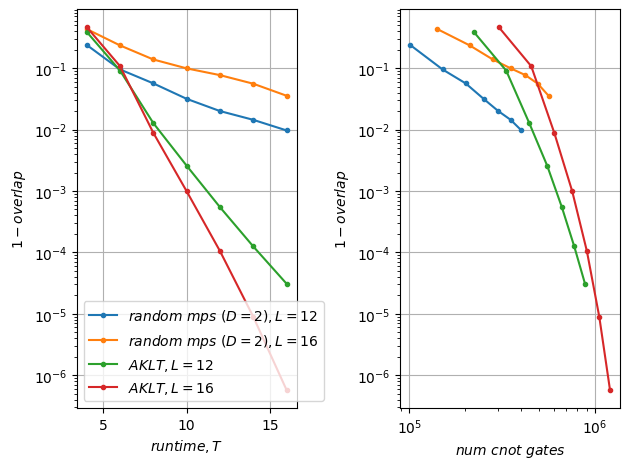

In [9]:
mps_labels = {"aklt": "AKLT",     
                "random": "random\ mps\ (D=2)",}
for mps_type in ['random', 'aklt']:
    for L in [12, 16]:
        data = load_obj(f"{mps_type}_{L}_data_adiabatic.pkl")
        xx = [(T, overlap, n_2qg) for T, (overlap, n_2qg) in data.items()]
        xx = np.array(xx)
        plt.subplot(1,2,1)
        plt.plot((xx[:,0]), (1-xx[:,1]), '.-', label=rf'${mps_labels[mps_type]},  L={L}$')
        plt.legend()
        plt.yscale('log')
        plt.xlabel(r'$runtime, T$')
        plt.ylabel(r'$1-overlap$')
        plt.grid(True)
        
        plt.subplot(1,2,2)
        plt.plot((xx[:,2]), (1-xx[:,1]), '.-', label=rf'${mps_labels[mps_type]},  L={L}$')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$num\ cnot\ gates$')
        plt.ylabel(r'$1-overlap$')
        plt.grid(True)
        
plt.tight_layout()